***
# COVID-19 Vaccination Progress - Modelling 
****

In [1]:
#common imports:
import numpy as np
import pandas as pd
from datetime import datetime
import os
from itertools import permutations

#import for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors
import seaborn as sns
import matplotlib.pyplot as plt



#for Modelling/timeseries:
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter


from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_pacf


from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_pacf
sns.set(rc={'figure.figsize':(20,15)})

#suppress pandas future warnings:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


    
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import ensemble
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [2]:
# load cleaned data time series:
df_time_m = pd.read_csv('timeseriesformodel.csv')

## Time series

For the vaccination progress we have daily observations points as daily vaccinations or people vaccinated per country.  Our target is to predict how the vaccination progress will continue in the next weeks. 

In [3]:
#set DatetimeIndex as index for our DataFrame:
df_daily = pd.read_csv('df2.csv', index_col=None)
#df_daily = df_daily.set_index('date')
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily.head(3)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines
0,Afghanistan,AFG,2021-02-23,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca
1,Afghanistan,AFG,2021-02-24,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca
2,Afghanistan,AFG,2021-02-25,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca


In [4]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   country                              7497 non-null   object        
 1   iso_code                             7497 non-null   object        
 2   date                                 7497 non-null   datetime64[ns]
 3   total_vaccinations                   4523 non-null   float64       
 4   people_vaccinated                    3983 non-null   float64       
 5   people_fully_vaccinated              7497 non-null   float64       
 6   daily_vaccinations                   7491 non-null   float64       
 7   total_vaccinations_per_hundred       4523 non-null   float64       
 8   people_vaccinated_per_hundred        3983 non-null   float64       
 9   people_fully_vaccinated_per_hundred  7497 non-null   float64       
 10  daily_vaccin

In [5]:
#df_daily.reset_index(inplace=True)

In [6]:
df_daily['day'] = df_daily['date'].dt.day
df_daily['month'] = df_daily['date'].dt.month
df_daily['year'] = df_daily['date'].dt.year
df_daily['weekday_name'] = df_daily['date'].dt.day_name()#day_of_week  
# Display a random sampling of 5 rows
df_daily.sample(5, random_state=0)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,day,month,year,weekday_name
4512,Mauritius,MUS,2021-02-02,NaN,NaN,0.0,58.0,NaN,NaN,0.00,46.0,Oxford/AstraZeneca,2,2,2021,Tuesday
2412,Finland,FIN,2021-02-09,227427.0,173558.0,53869.0,9065.0,4.10,3.13,0.97,1636.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",9,2,2021,Tuesday
4732,Mongolia,MNG,2021-03-11,48265.0,NaN,0.0,5009.0,1.47,NaN,0.00,1528.0,Oxford/AstraZeneca,11,3,2021,Thursday
4245,Luxembourg,LUX,2021-01-08,NaN,NaN,0.0,62.0,NaN,NaN,0.00,99.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",8,1,2021,Friday
5700,Qatar,QAT,2021-03-11,NaN,NaN,0.0,15381.0,NaN,NaN,0.00,5339.0,Pfizer/BioNTech,11,3,2021,Thursday


In [7]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [8]:
df_time = df_daily.copy()
df_time.set_index('date')
df_time = df_time[['date','country', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time.sample(5)

,date,country,daily_vaccinations,people_fully_vaccinated_per_hundred
6566,2021-03-10,South Africa,6474.0,0.22
5785,2021-03-09,Romania,45038.0,3.45
4666,2021-01-29,Monaco,294.0,0.00
2889,2021-03-18,Guatemala,5748.0,0.00
2119,2021-03-22,Dominican Republic,15625.0,0.00


In [9]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

,ID
date,0
country,0
daily_vaccinations,6
people_fully_vaccinated_per_hundred,0


In [10]:
df_time.dropna(axis=0)

,date,country,daily_vaccinations,people_fully_vaccinated_per_hundred
0,2021-02-23,Afghanistan,1367.0,0.0
1,2021-02-24,Afghanistan,1367.0,0.0
2,2021-02-25,Afghanistan,1367.0,0.0
3,2021-02-26,Afghanistan,1367.0,0.0
4,2021-02-27,Afghanistan,1367.0,0.0
...,...,...,...,...
7492,2021-03-20,Zimbabwe,836.0,0.0
7493,2021-03-21,Zimbabwe,910.0,0.0
7494,2021-03-22,Zimbabwe,805.0,0.0
7495,2021-03-23,Zimbabwe,655.0,0.0


In [11]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

,ID
date,0
country,0
daily_vaccinations,6
people_fully_vaccinated_per_hundred,0


In [12]:
df_time.isnull().any()

date                                   False
country                                False
daily_vaccinations                      True
people_fully_vaccinated_per_hundred    False
dtype: bool

In [13]:
df_time.dropna(inplace = True)

In [14]:
#check for missing values in %
round(100*(df_time.isnull().sum()/len(df_time.index)),0)

date                                   0.0
country                                0.0
daily_vaccinations                     0.0
people_fully_vaccinated_per_hundred    0.0
dtype: float64

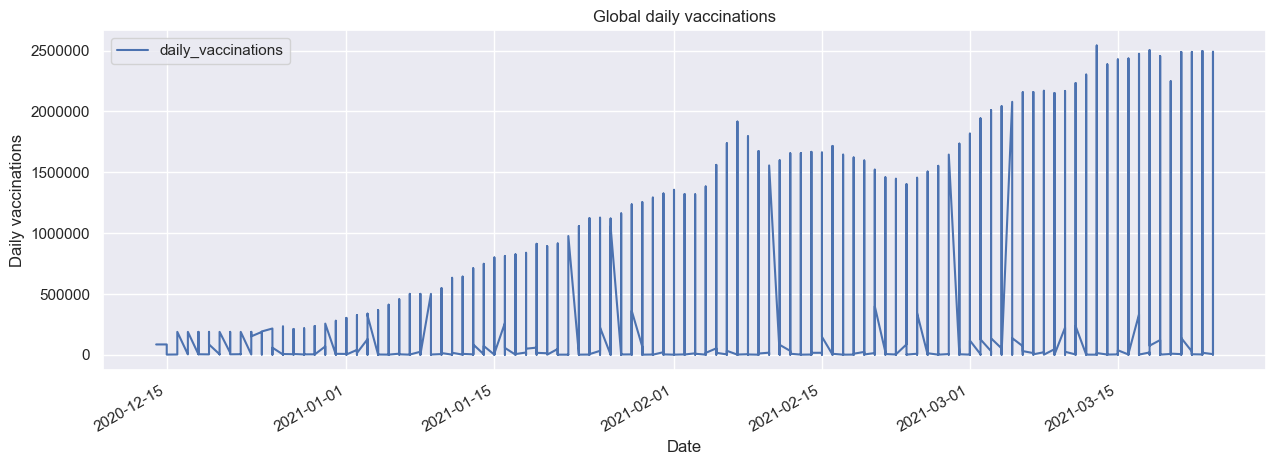

In [15]:
# plot the time series for daily vaccinations:
df_time1= df_time[['date','daily_vaccinations']]
df_time1.set_index('date', inplace=True)
ax1 = df_time1.plot()
# Add title and axis names

ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Global daily vaccinations')
plt.xlabel('Date')
plt.ylabel('Daily vaccinations')

plt.show()

## Modelling with data for the United States

In [16]:
#Select data for the United States only:
df_time_us = df_time[df_time.country == 'United States']
df_time_us

,date,country,daily_vaccinations,people_fully_vaccinated_per_hundred
7313,2020-12-21,United States,57909.0,0.00
7314,2020-12-22,United States,127432.0,0.00
7315,2020-12-23,United States,150606.0,0.00
7316,2020-12-24,United States,191001.0,0.00
7317,2020-12-25,United States,215238.0,0.00
...,...,...,...,...
7402,2021-03-20,United States,2248285.0,12.87
7403,2021-03-21,United States,2488734.0,13.20
7404,2021-03-22,United States,2489697.0,13.43
7405,2021-03-23,United States,2497025.0,13.61


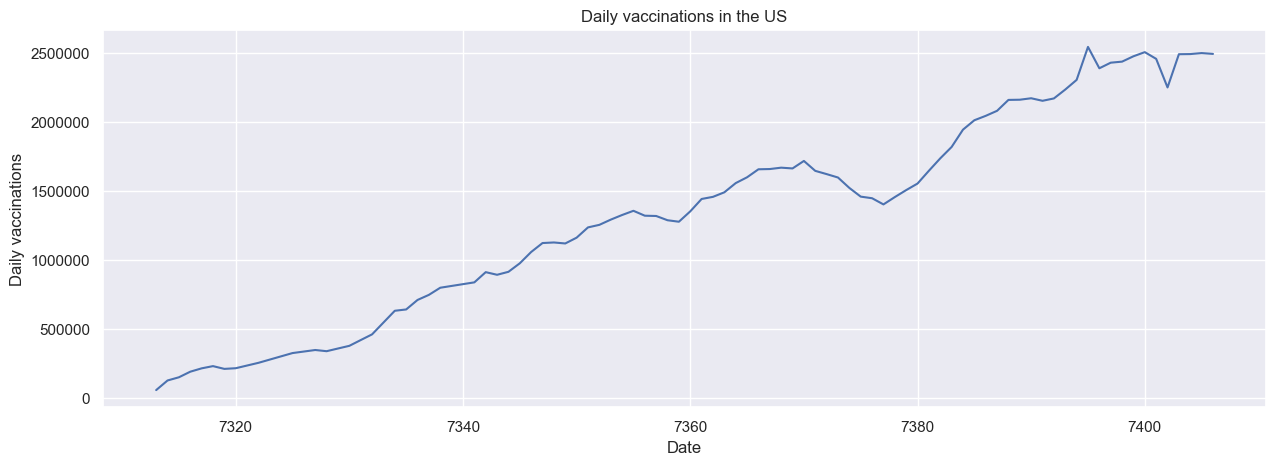

In [17]:
#df_time_us.set_index('date', inplace=True)

ax1 = df_time_us['daily_vaccinations'].plot()
# Add title and axis names

ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Daily vaccinations in the US')
plt.xlabel('Date')
plt.ylabel('Daily vaccinations')

plt.show();

## Check for Stationarity

Stationarity: A time series is stationary if its statistical properties (e.g. mean, variance, etc.) are the same throughout the series, independently of the point in time where they were observed. There are no long-term predictable patterns such as trend or seasonality. Plots will show a roughly horizontal trend with constant variance.

We use the decomposition method which allows us to separately view seasonality, trend and random which is the variability in the data set after removing the effects of the seasonality and trend.

Trend: Increase and decrease in the value of the data. It can further be divided into global and local trends.

Seasonality: Repetitive pattern of fixed frequency that is visible in the data.

Noise/Resiudals: Random data that can be obtained after extracting the trend and seasonal component.

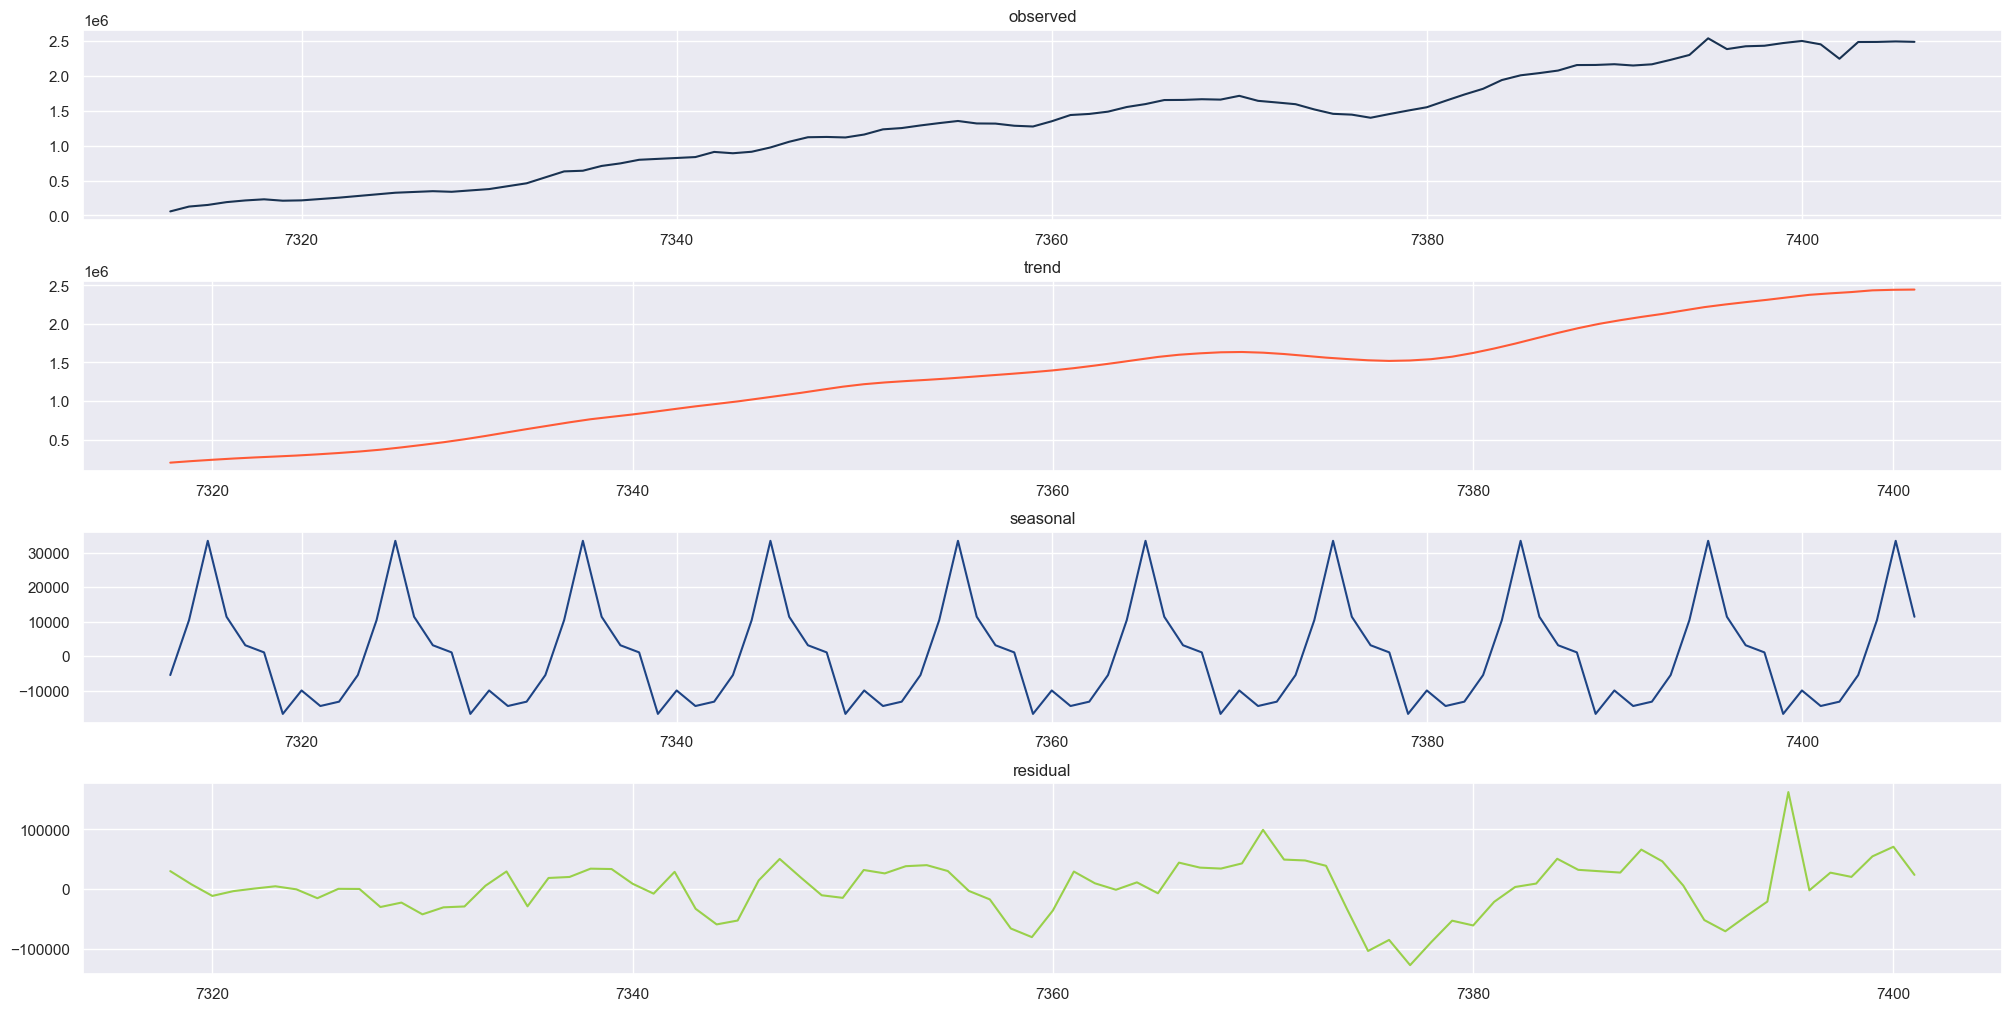

In [18]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time_us['daily_vaccinations'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

The daily vaccinations for the United States have a clear increasing trend and a weekly seasonality. That means it is not stationary.

----

Statistical test: To confirm our visual observation on the above plot, we will use ADF and KPSS test:

----

ADF (Augemented Dickey-Fuller):

Null Hypothesis: The series is not stationary.

Alternate Hypothesis: The series is stationary.

----

KPSS (Kwiatkowski-Phillips-Schmidt-Shin):

Null Hypothesis: The series is stationary.

Alternated Hypothesis: The series is not stationary.




ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -0.520049
p-value: 0.888044
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.815044
p-value: 0.010000
----------------------------------------


/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


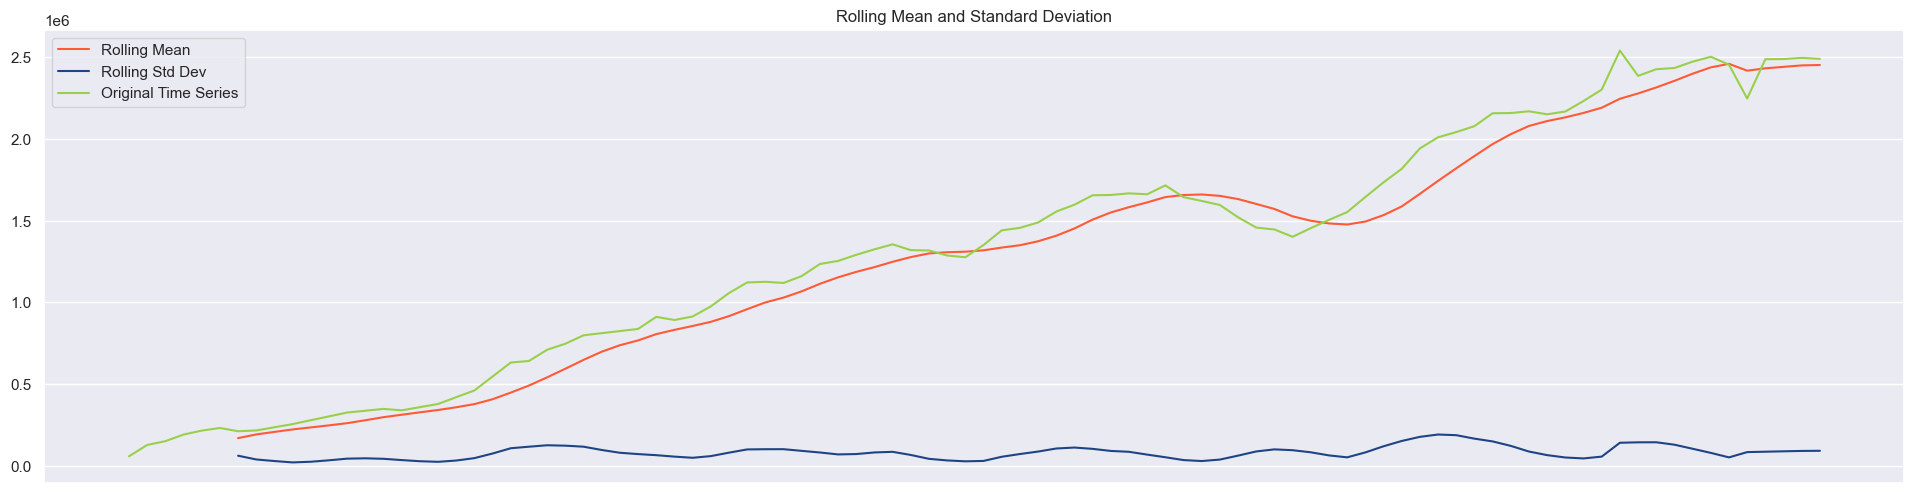

In [19]:
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(7).mean()
    rolling_std_dev = daily_vaccinations.rolling(7).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time_us['daily_vaccinations'])

The p-value of the ADF test is > 0.5 which tells us that we cannot decline the null-hypothesis that the time series is non-stationary and the p-value for the KPSS test is below 0.05 which means we can reject this null-hypothesis that it is stationary. Both tests indicates that it is not stationary.

We need to de-trend the time series and make the series stationary.

In [20]:
# De-trending the time series
df_time_us_diff = df_time_us['daily_vaccinations'].diff(periods =2).dropna()

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -5.096813
p-value: 0.000014
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.057998
p-value: 0.100000
----------------------------------------


/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


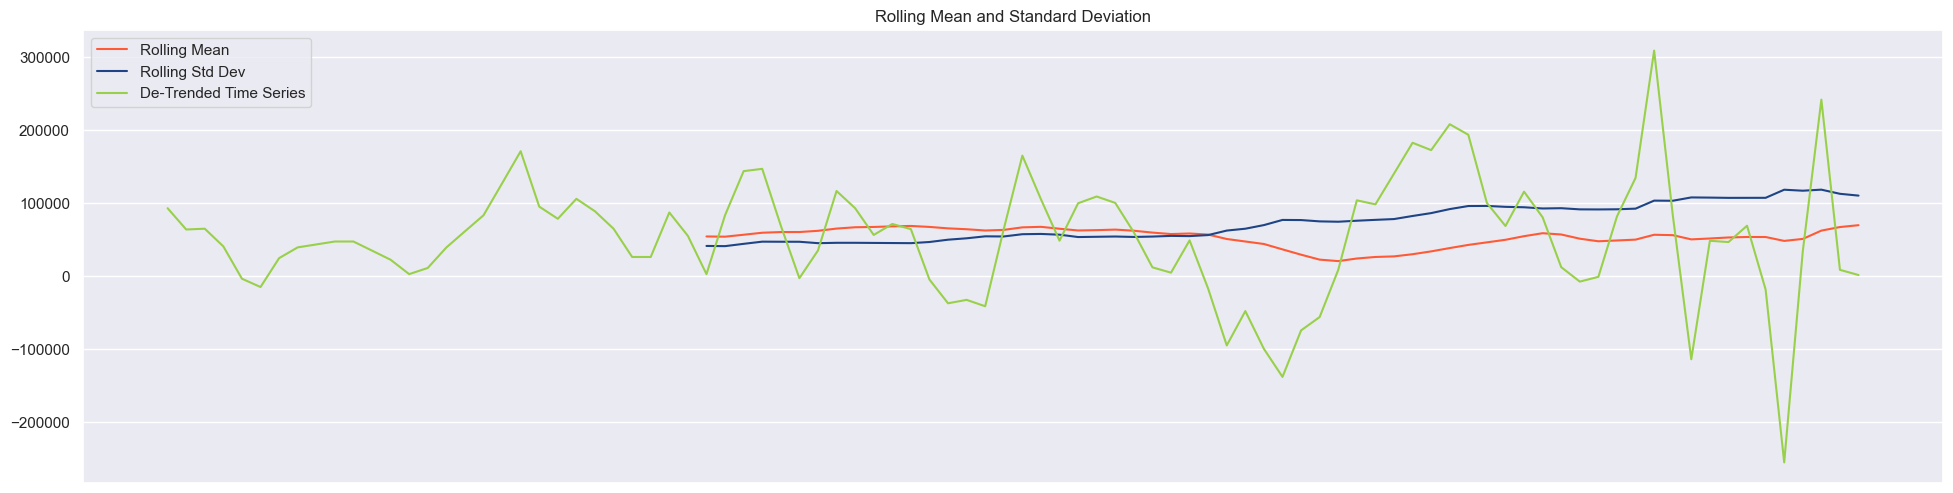

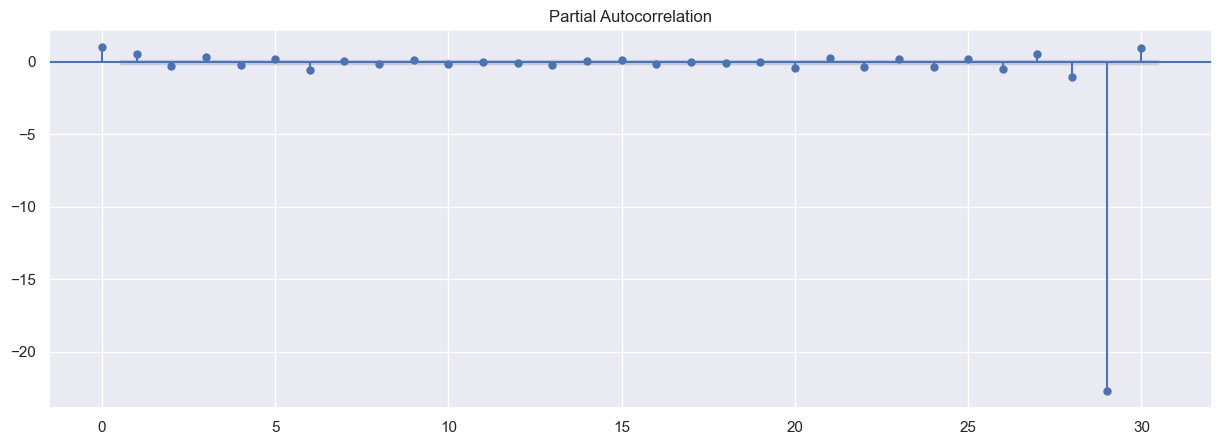

In [21]:
#re-test stationarity:
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='De-Trended Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
#stationarity_test(df_time_us['Dailyvac_Detrend'].dropna())  df_time_us_diff
stationarity_test(df_time_us_diff)             
# Partial Autocorrelation Plot
#pacf = plot_pacf(df_time_us['Dailyvac_Detrend'].dropna(), lags=30)
pacf = plot_pacf(df_time_us_diff, lags=30)

After de-trending the time series the AFD test as well as the KPSS test both indicate that our series is now stationary. Having a look at the partial autocorrelation plot suggests that correlation exists at certain lags.

## Split the Data

We will split our data and take the first part as our training set.

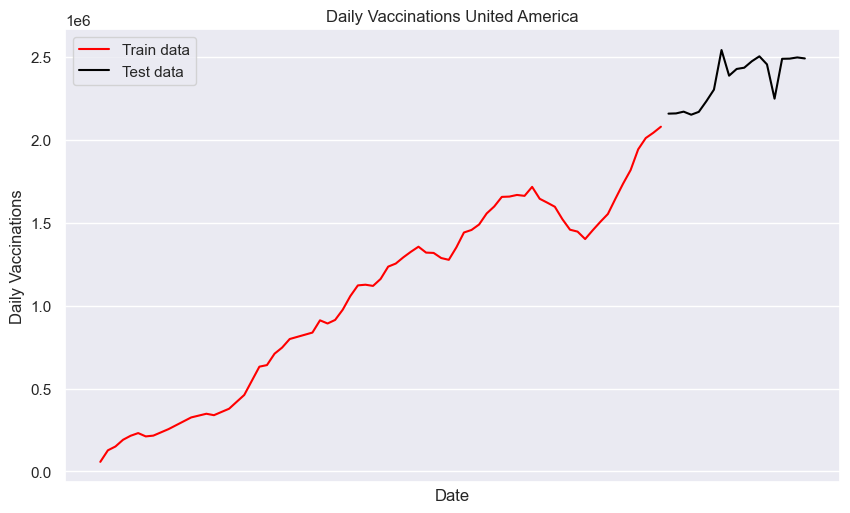

In [22]:
# Split data into train and test set
df_arima = df_time_us['daily_vaccinations']
train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.title('Daily Vaccinations United America')
plt.xlabel('Date')
plt.ylabel('Daily Vaccinations')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

### Auto-Regressive Integrated Moving Average (ARIMA)

ARIMA model is a combination of Auto-Regressive and Moving Average model along with the Integration of differencing. Auto-Regressive model determines the relationship between an observation and a certain number of lagged observations. The Integrated part is the differencing of the actual observations to make the time series stationary. Moving Average determines the relationship between an observation and residual error obtained by using a moving average model on the lagged observations.

* *Auto-Regressive (p)*: Number of lag observations in the model. Also called lag order.
* *Integrated (d)*: Number of times the actual observations are differenced for stationarity. Also called degree of differencing.
* *Moving Average (q)*: Size of moving average window. Also called the order of moving average.

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1758.067, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1749.903, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1745.630, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1747.536, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1747.655, Time=0.02 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.234 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   75
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -870.815
Date:                Sat, 24 Apr 2021   AIC                           1745.630
Time:                        21:36:46   BIC                           1750.211
Sample:                          

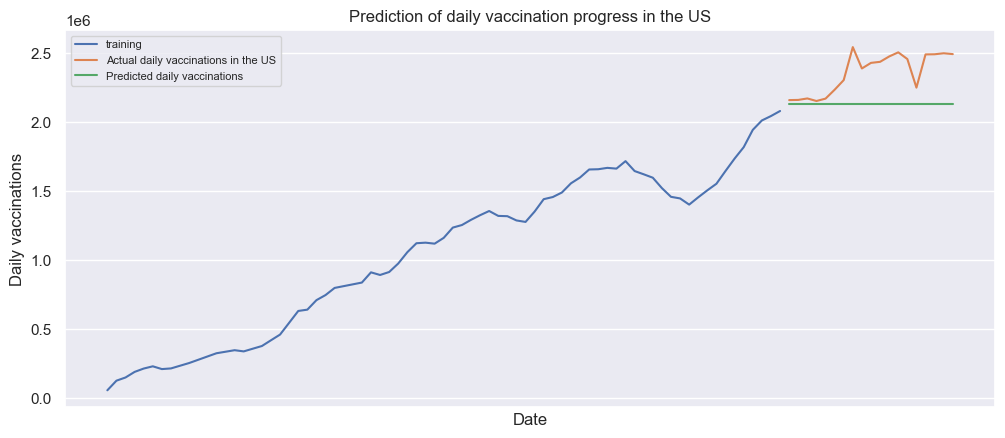

Auto-Arima RMSE :- 271015.731


In [23]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = True,
                      stepwise=True, with_intercept=False,
                      )

# Fit the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual daily vaccinations in the US')
plt.plot(fcv_series,label='Predicted daily vaccinations')
plt.title('Prediction of daily vaccination progress in the US')
plt.xlabel('Date')
plt.ylabel('Daily vaccinations')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

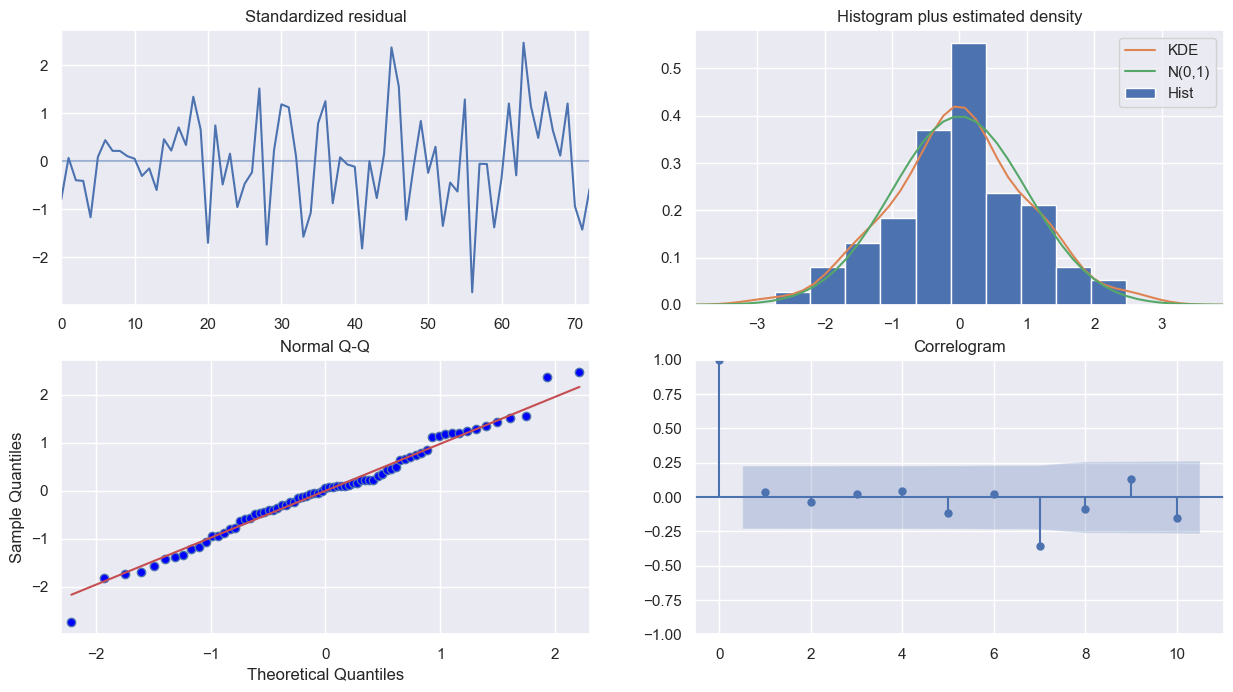

In [24]:
# Plotting diagnostics of the ARIMA model
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

Histogram plus estimated density plot: The red KDE line follows closely with the N(0,1) line. This is a good indication that the residuals are normally distributed.

The Q-Q-plot: Shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0,1). This is an indication that the residuals are normally distributed.

The Correlogram plot: Shows that the time series residuals have low correlation with lagged versions of itself.

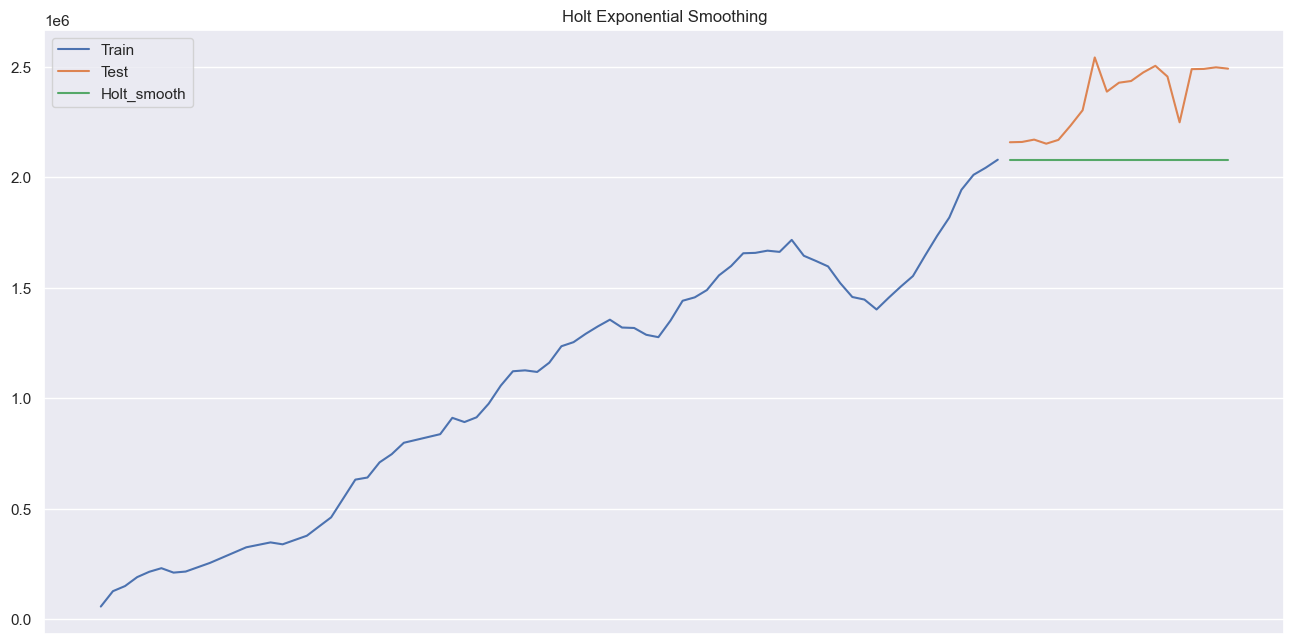

Holt’s Exponential Smoothing RMS :- 312111.348 & Smoothing Level :- 1.0 & Smoothing Slope :- 0.05


In [25]:
# Holt's Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)
Holt_smooth_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
    fit_Holt_smooth = ExponentialSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_smooth'] = fit_Holt_smooth.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_smooth)),3)
    Holt_smooth_df = Holt_smooth_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = Holt_smooth_df.loc[Holt_smooth_df['RMS'] == min(Holt_smooth_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_Holt_smooth = ExponentialSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_smooth'] = fit_Holt_smooth.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_smooth'], label='Holt_smooth')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_smooth))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

## Simple Exponential Smoothing

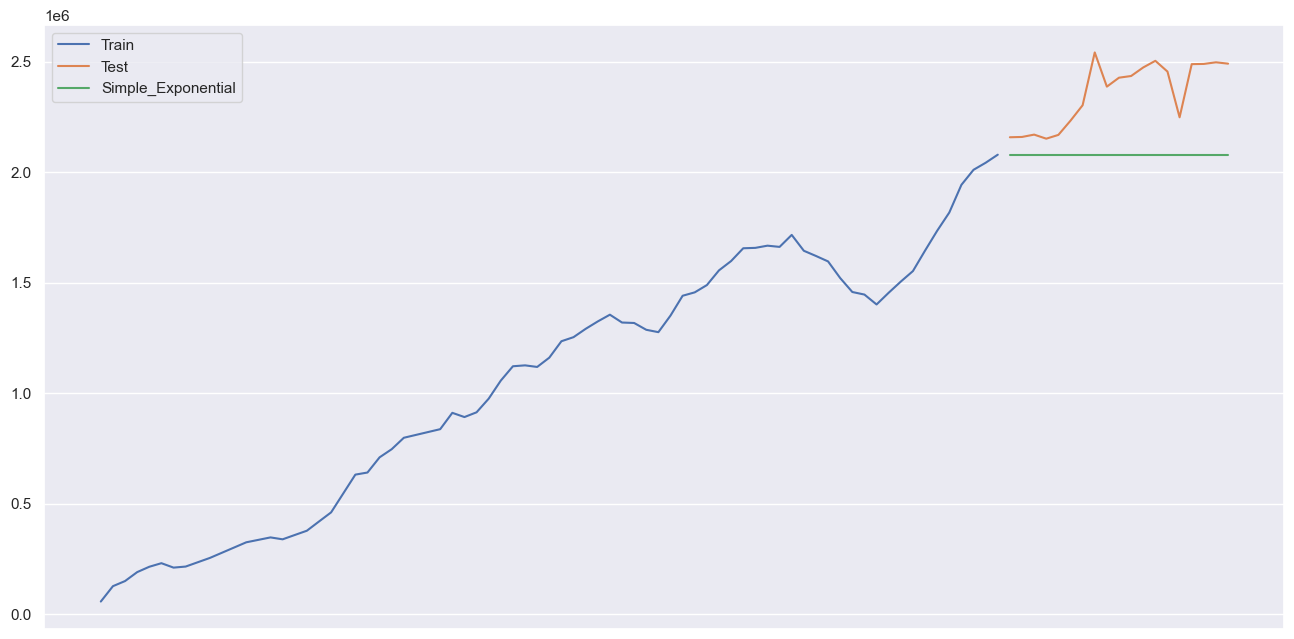

Simple Exponential Smoothing RMS :- 312111.348 & Smoothing Level :- 1.0


In [26]:
# Simple Exponential Smoothing Method

simple_exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
    fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
    pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
    simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = simple_exponential_df.loc[simple_exponential_df['RMS'] == min(simple_exponential_df['RMS']),['Smoothing Level']].values


# Use optimised values from the lists
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.xticks([])
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

## Evaluation of the Models

To evaluate the performance of the model, we will use Root Mean Squared Error (RMSE) and compare which model performed the best.

In [27]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

RMSE of all the methods
Auto-Arima:  271015.731
Simple Exponential Smoothing:  312111.348
Holt’s Exponential Smoothing:  312111.348


From the three models we trained the Auto-Arima reached the smallest RSME but all three models do not deliver a good prediction yet.

## Future Work:
- Tune models for better predictions
- If required use other models
- Use updated dataset for more data